- use the dataset created by analysis/sos/create_turbulence_dataset.ipynb 
- clean the latent heat flux data using QC Flags and an outlier threshold (5*sigma)
- analyze how sensitive latent heat flux measurements are to the QC flags and including/excluding them
  - output: table table for publication
- plot cumulative sublimation plots
  - output: figure for publication
- save the dataset with the cleaned latent heat flux data for further use

In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable('json')

from sublimpy import turbulence
import matplotlib.pyplot as plt
from sublimpy import tidy
import metpy.constants

# Open data

## Open precipitation dataset

In [2]:
precip_file = "/storage/elilouis/sublimationofsnow/tilden_precip_data/kettle_ponds_precip.csv"

precip_df = pd.read_csv(precip_file)

precip_df['date'] = pd.to_datetime(precip_df['date'])

acc_precip_on_first_day = precip_df.set_index('date').loc['20221130'].acc_prec

precip_df = precip_df.set_index('date').loc['20221130': '20230510'].reset_index()
precip_df['acc_prec']  = precip_df['acc_prec'] - acc_precip_on_first_day

## Open SOS Measurement Dataset

In [3]:
start_date = '20221130'
end_date = '20230509'
# open files
tidy_df_5Min = pd.read_parquet(f'../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
tidy_df_30Min = pd.read_parquet(f'../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet')
# convert time column to datetime
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df_5Min = tidy_df_5Min.set_index('time').sort_index().loc[start_date:end_date].reset_index()
tidy_df_30Min = tidy_df_30Min.set_index('time').sort_index().loc[start_date:end_date].reset_index()

In [4]:
# quick way to get variable info if we want it 
# import xarray as xr
# ds = xr.open_dataset("/storage/elilouis/sublimationofsnow/sosnoqc/isfs_20221228.nc")
# ds['SWE_p2_c']

## Open Modeled Dataset

In [5]:
# Open Model Ensemble Dataset
model_df = pd.read_parquet("model_results.parquet")
# add a bunch of columns that are descriptive, from the config column which has multiple bits of info
model_df['z0'] = model_df['config'].apply(
    lambda v: float(v.split(' ')[-1])
)
model_df['e_sat_curve'] = model_df['config'].apply(
    lambda v: 'metpy' if 'metpy' in v else 'alduchov'
)
model_df['surface_measurement'] = model_df['config'].apply(
    lambda v: v.split(' ')[-3]
)
model_df['scheme'] = model_df['config'].apply(
    lambda v: 'andreas' if 'andreas lengths' in v else 'yang'
)
model_df['most_config'] = model_df['config'].apply(lambda s: ' '.join(s.split(' ')[:-3]))
# remove the scalar roughness length parameterization info 
model_df['most_config'] = model_df['most_config'].str.replace(' andreas lengths', '')
model_df.head()
### Handle a pesky outlier
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'latent heat flux'] = 0
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'sensible heat flux'] = 0
## Calculate cumulative sublimation (mm)
### Modeled data

In [6]:
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2)))

In [7]:
targets = tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20230131': '20230315']['value']
predictions = model_df[
    model_df.config == "MO Holtslag de Bruin Tsurf_c e_sat_alduchov 1e-05"
].set_index('time').loc['20230131': '20230315']['latent heat flux']
nse(predictions, targets)

-0.1685537899718823

Text(0.5, 1.0, 'NSE = -0.1685537899718823')

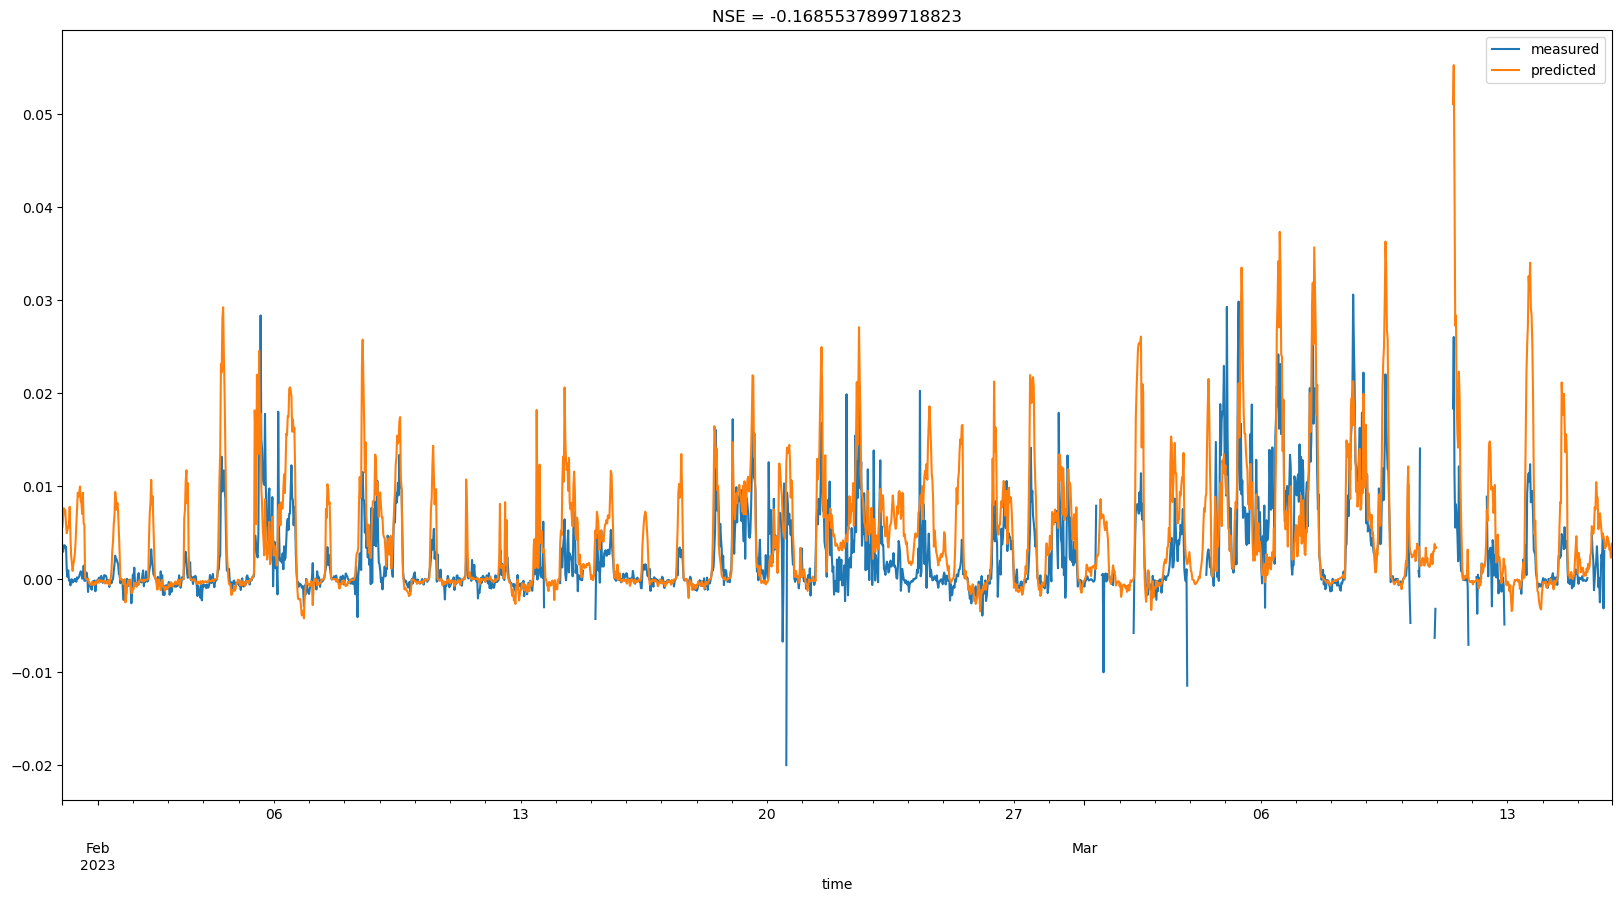

In [8]:
plt.figure(figsize=(20,10))
targets = tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20230131': '20230315']['value']
predictions = model_df[
    model_df.config == "MO Holtslag de Bruin Tsurf_c e_sat_alduchov 1e-05"
].set_index('time').loc['20230131': '20230315']['latent heat flux']

targets.plot(label='measured')
predictions.plot(label='predicted')
plt.legend()
plt.title(f"NSE = {nse(predictions, targets)}")

In [9]:
ec_lhflux_and_counts_variables = [
    # ('w_h2o__2m_c', 'counts_2m_c_1'), 
    ('w_h2o__3m_c', 'counts_3m_c_1'), 
    ('w_h2o__5m_c', 'counts_5m_c_1'), 
    ('w_h2o__10m_c', 'counts_10m_c_1'), 
    ('w_h2o__15m_c', 'counts_15m_c_1'), 
    ('w_h2o__20m_c', 'counts_20m_c_1'), 


    # ('w_h2o__1m_d', 'counts_1m_d_1'), 
    ('w_h2o__3m_d', 'counts_3m_d_1'), 
    ('w_h2o__10m_d', 'counts_10m_d_1'), 
      
    # ('w_h2o__1m_ue', 'counts_1m_ue_1'), 
    ('w_h2o__3m_ue', 'counts_3m_ue_1'), 
    ('w_h2o__10m_ue', 'counts_10m_ue_1'), 


    # ('w_h2o__1m_uw',  'counts_1m_uw_1'), 
    ('w_h2o__3m_uw', 'counts_3m_uw_1'), 
    ('w_h2o__10m_uw', 'counts_10m_uw_1'), 
]
ec_lhflux_variables = list(zip(*ec_lhflux_and_counts_variables))[0]

# Compare blowing snow with data counts

In [10]:
counts_variables = list(list(zip(*ec_lhflux_and_counts_variables))[1])

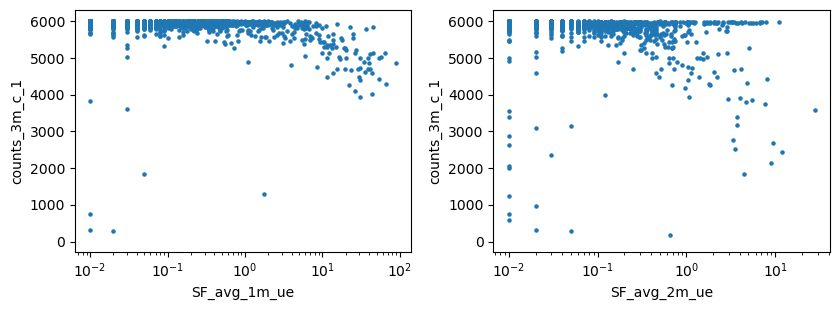

In [11]:
fig, axes = plt.subplots(1,2, figsize=(8.5, 3.2))
axes[0].scatter(
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    tidy_df_5Min.query("variable == 'counts_3m_c_1'").value,
    s=5
)
axes[0].set_xscale('log')
axes[0].set_xlabel('SF_avg_1m_ue')
axes[0].set_ylabel('counts_3m_c_1')

axes[1].scatter(
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    tidy_df_5Min.query("variable == 'counts_3m_c_1'").value,
    s=5
)
axes[1].set_xscale('log')
axes[1].set_xlabel('SF_avg_2m_ue')
axes[1].set_ylabel('counts_3m_c_1')
plt.tight_layout()

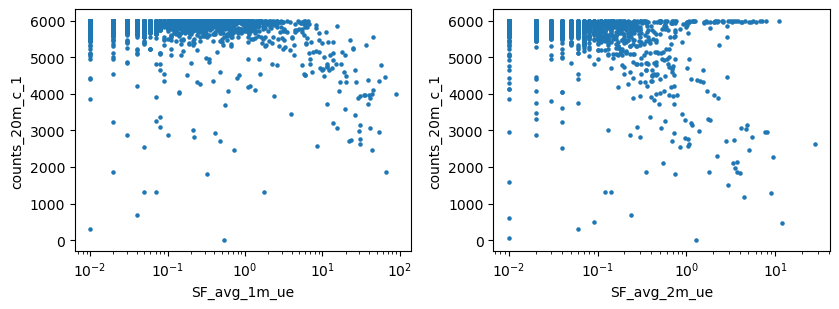

In [12]:
fig, axes = plt.subplots(1,2, figsize=(8.5, 3.2))
axes[0].scatter(
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    tidy_df_5Min.query("variable == 'counts_20m_c_1'").value,
    s=5
)
axes[0].set_xlabel('SF_avg_1m_ue')
axes[0].set_ylabel('counts_20m_c_1')
axes[0].set_xscale('log')

axes[1].scatter(
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    tidy_df_5Min.query("variable == 'counts_20m_c_1'").value,
    s=5
)
axes[1].set_xlabel('SF_avg_2m_ue')
axes[1].set_ylabel('counts_20m_c_1')
axes[1].set_xscale('log')
plt.tight_layout()

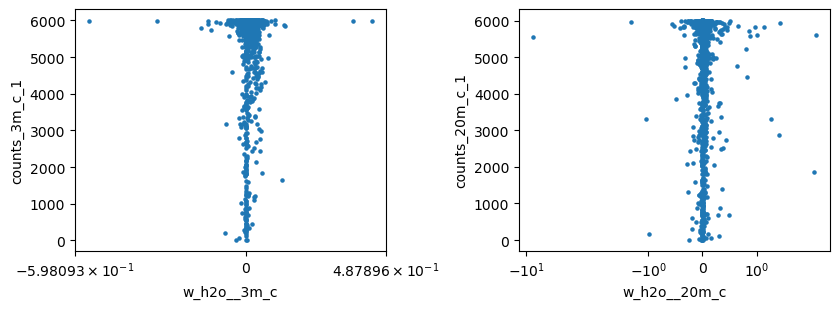

In [13]:
fig, axes = plt.subplots(1,2, figsize=(8.5, 3.2))
axes[0].scatter(
    tidy_df_5Min.query("variable == 'w_h2o__3m_c'").value,
    tidy_df_5Min.query("variable == 'counts_3m_c_1'").value,
    s=5
)
axes[0].set_xlabel('w_h2o__3m_c')
axes[0].set_ylabel('counts_3m_c_1')
axes[0].set_xscale('symlog')

axes[1].scatter(
    tidy_df_5Min.query("variable == 'w_h2o__20m_c'").value,
    tidy_df_5Min.query("variable == 'counts_20m_c_1'").value,
    s=5
)
axes[1].set_xlabel('w_h2o__20m_c')
axes[1].set_ylabel('counts_20m_c_1')
axes[1].set_xscale('symlog')
plt.tight_layout()

# Clean the EC data and calculate cumulative sublimation

## Calculate the upper and lower threshold for removing data - 5*std deviation of ALL latent heat flux measurements

In [14]:
all_lhflux_measurements = tidy_df_5Min[tidy_df_5Min.variable.isin(ec_lhflux_variables)].value
lower_threshold = all_lhflux_measurements.mean() - 5*all_lhflux_measurements.std()
upper_threshold = all_lhflux_measurements.mean() + 5*all_lhflux_measurements.std()
lower_threshold, upper_threshold

(-15.63557720571385, 15.649918135695943)

## Examine sensitivity of sublimation estimates to %-required threshold

In [15]:
import pandas as pd
import numpy as np

good_data_fractions = [
    0, 
    0.05, 0.1, 
    0.25, 0.50, 0.75, 
    0.90, 0.95, 
    1
]
dataframes = []
for good_data_fraction in good_data_fractions:
    for flux_var, counts_var in ec_lhflux_and_counts_variables:
        flux_values = tidy_df_5Min.query(f"variable == '{flux_var}'").value.values
        nan_count_b4_processing = pd.isnull(flux_values).sum()
        new_values = turbulence.clean_eddy_covariance(
            flux_values,
            tidy_df_5Min.query(f"variable == '{counts_var}'").value.values,
            lower_threshold,
            upper_threshold,
            fraction_good_data_reqd = good_data_fraction
        )
        nan_count_after_processing = pd.isnull(new_values).sum()
        print(good_data_fraction, flux_var, nan_count_b4_processing, nan_count_after_processing)
        dataframes.append(
            pd.DataFrame.from_dict({
                flux_var: new_values,
                'good_data_fraction': np.full(len(new_values), good_data_fraction)
            })
        )

0 w_h2o__3m_c 4399 4399
0 w_h2o__5m_c 2745 2745
0 w_h2o__10m_c 3296 3298
0 w_h2o__15m_c 1854 1854
0 w_h2o__20m_c 2586 2586
0 w_h2o__3m_d 5034 5035
0 w_h2o__10m_d 4516 4516
0 w_h2o__3m_ue 4728 4729
0 w_h2o__10m_ue 4493 4493
0 w_h2o__3m_uw 4707 4707
0 w_h2o__10m_uw 4948 4950
0.05 w_h2o__3m_c 4399 4412
0.05 w_h2o__5m_c 2745 2754
0.05 w_h2o__10m_c 3296 3307
0.05 w_h2o__15m_c 1854 1878
0.05 w_h2o__20m_c 2586 2620
0.05 w_h2o__3m_d 5034 5062
0.05 w_h2o__10m_d 4516 4531
0.05 w_h2o__3m_ue 4728 4757
0.05 w_h2o__10m_ue 4493 4500
0.05 w_h2o__3m_uw 4707 4723
0.05 w_h2o__10m_uw 4948 4969
0.1 w_h2o__3m_c 4399 4426
0.1 w_h2o__5m_c 2745 2759
0.1 w_h2o__10m_c 3296 3318
0.1 w_h2o__15m_c 1854 1888
0.1 w_h2o__20m_c 2586 2635
0.1 w_h2o__3m_d 5034 5078
0.1 w_h2o__10m_d 4516 4547
0.1 w_h2o__3m_ue 4728 4782
0.1 w_h2o__10m_ue 4493 4510
0.1 w_h2o__3m_uw 4707 4735
0.1 w_h2o__10m_uw 4948 4979
0.25 w_h2o__3m_c 4399 4461
0.25 w_h2o__5m_c 2745 2789
0.25 w_h2o__10m_c 3296 3351
0.25 w_h2o__15m_c 1854 1941
0.25 w_h2o__2

In [16]:
seconds_per_5min = 60*5

variable_ls = []
height_ls = []
percent_reqd_ls = []
cumulative_sublimation_ls = []

for dataframe in dataframes:
    flux_var_name = dataframe.columns[0]
    height = int(flux_var_name.split('_')[-2].split('m')[0])
    tower = flux_var_name.split('_')[-1]
    good_data_fraction = dataframe['good_data_fraction'].iloc[0]
    new_var_name = f"cumulative_sub_measured_{height}m_{tower}"
    cumulative_sublimation_values = np.nancumsum(
        dataframe[flux_var_name]*seconds_per_5min
    )/metpy.constants.density_water.magnitude
    ec_lhflux_variables = list(zip(*ec_lhflux_and_counts_variables))[0]
    variable_ls.append(new_var_name)
    height_ls.append(height)
    percent_reqd_ls.append(good_data_fraction)
    cumulative_sublimation_ls.append(cumulative_sublimation_values.max())

In [17]:
percentreqd_qc_df = pd.DataFrame({
    'variable': variable_ls,
    'height': height_ls,
    'percent_reqd': percent_reqd_ls,
    'cumulative_sublimation': cumulative_sublimation_ls,
})
alt.Chart(percentreqd_qc_df).mark_line(point=True).transform_filter(alt.datum.height > 1).encode(
    alt.X("percent_reqd:Q").title("% 'good' data req'd per 5min average"),
    alt.Y("cumulative_sublimation:Q").title("Seasonal sublimation (mm)"),
    alt.Color("height:O").scale(scheme='viridis'),
    detail = 'variable:N',
    tooltip = 'variable:N'
)

alt.Chart(...)

## Select our data-required value

In [18]:
dataframes = [df for df in dataframes if df['good_data_fraction'].iloc[0] == 0.90]

## Examine how calculated cumulative sublimation values var for different interpolation-window-limits, substitute clean data for old/dirty date (using 12-timestep gap limit), and add cumulative sublimation values to the dataset

In [19]:
seconds_per_5min = 60*5

flux_var_name_ls = []
height_ls = []
interp_window_limit_ls = []
cumsum_with_interp_ls = []

for dataframe in dataframes:
    flux_var_name = dataframe.columns[0]
    height = int(flux_var_name.split('_')[-2].split('m')[0])
    tower = flux_var_name.split('_')[-1]
    new_var_name = f"cumulative_sub_measured_{height}m_{tower}"
    # Print calculated cumulative sublimation values for different interpolation-window-limits
    for interp_window_limit in [None, 1, 2, 5, 10, 12, 20, 30, 80, 100, 200, 300, 800, 1000]:
            flux_var_name_ls.append(flux_var_name)
            height_ls.append(height)
            interp_window_limit_ls.append(interp_window_limit)
            cumsum_with_interp_ls.append((np.nancumsum(
                (dataframe[flux_var_name]*seconds_per_5min).interpolate(method='linear', limit=interp_window_limit)
            )/metpy.constants.density_water.magnitude).max()
        )
        
    cumulative_sublimation_values = np.nancumsum(
        (dataframe[flux_var_name]*seconds_per_5min).interpolate(method='linear', limit=12)
    )/metpy.constants.density_water.magnitude
    # remove the old flux values
    tidy_df_5Min = tidy_df_5Min[tidy_df_5Min.variable != flux_var_name]
    # # add the new (cleaned) flux values
    tidy_df_5Min = tidy.tidy_df_add_variable(
        tidy_df_5Min,
        dataframe[flux_var_name],
        flux_var_name,
        'w_h2o_',
        height,
        tower
    )
    # add the cumulative calculations values
    tidy_df_5Min = tidy.tidy_df_add_variable(
        tidy_df_5Min,
        cumulative_sublimation_values,
        new_var_name,
        "Cumulative sublimation measured",  
        height,
        tower
    )

In [20]:
gapsize_qc_df= pd.DataFrame({
    'variable': flux_var_name_ls,
    'height': height_ls,
    'max_interp_limit': interp_window_limit_ls,
    'cumulative_sub': cumsum_with_interp_ls,
})

alt.Chart(gapsize_qc_df).mark_line(point=True).transform_filter(alt.datum.height > 1).encode(
    alt.X("max_interp_limit:Q").title("max gap size for interpolation").scale(type='log'),
    alt.Y("cumulative_sub:Q").title("Seasonal sublimation (mm)"),
    alt.Color("height:O").scale(scheme='viridis'),
    detail = 'variable:N',
    tooltip='variable:N'
)

alt.Chart(...)

In [21]:
data_clean_steps_df = pd.merge(
    percentreqd_qc_df.query("percent_reqd == 0")[['variable','cumulative_sublimation']].rename(
        columns = {'cumulative_sublimation': 'cumulative_sublimation_raw'}
    ),
    gapsize_qc_df.assign(variable = gapsize_qc_df.variable.str.replace(
        'w_h2o__', 'cumulative_sub_measured_'
    )).query("max_interp_limit == 12").rename(
        columns = {'cumulative_sub': 'cumulative_sublimation_gapfilled'}
    ),
    on='variable'
).merge(
    percentreqd_qc_df.query("percent_reqd == 0.9")[['variable','cumulative_sublimation']].rename(
        columns = {'cumulative_sublimation': 'cumulative_sublimation_filtered'}
    ),
    on='variable'
)

In [22]:
data_clean_steps_df['tower'] = data_clean_steps_df.variable.apply(lambda s:s.split('_')[-1])
data_clean_steps_df = data_clean_steps_df[
    ['variable', 'tower', 'height', 'cumulative_sublimation_raw', 'cumulative_sublimation_filtered', 'cumulative_sublimation_gapfilled']
].round(2)
data_clean_steps_df = data_clean_steps_df.rename(columns={
    'cumulative_sublimation_raw': 'raw',
    'cumulative_sublimation_filtered': 'filtered',
    'cumulative_sublimation_gapfilled': 'gapfilled',
})

In [23]:
data_clean_steps_df

,variable,tower,height,raw,filtered,gapfilled
0,cumulative_sub_measured_3m_c,c,3,34.46,33.62,34.33
1,cumulative_sub_measured_5m_c,c,5,37.44,36.37,36.85
2,cumulative_sub_measured_10m_c,c,10,41.32,39.28,40.55
3,cumulative_sub_measured_15m_c,c,15,32.56,25.61,29.67
4,cumulative_sub_measured_20m_c,c,20,38.72,33.81,36.60
5,cumulative_sub_measured_3m_d,d,3,34.01,32.44,32.57
6,cumulative_sub_measured_10m_d,d,10,39.17,37.47,54.87
7,cumulative_sub_measured_3m_ue,ue,3,34.56,32.30,29.73
8,cumulative_sub_measured_10m_ue,ue,10,36.66,34.14,35.05
9,cumulative_sub_measured_3m_uw,uw,3,34.39,33.27,34.11


In [24]:
vars = [
    'raw',	'filtered',	'gapfilled'
    ]
alt.Chart(data_clean_steps_df).mark_line().transform_fold(
    vars
).encode(
    alt.Y("key:O", sort=vars),
    alt.X("value:Q"),
    alt.Color('height:N'),
    detail = 'variable'
)

alt.Chart(...)

Text(0.5, 1.0, 'NSE = -0.1685537899718823')

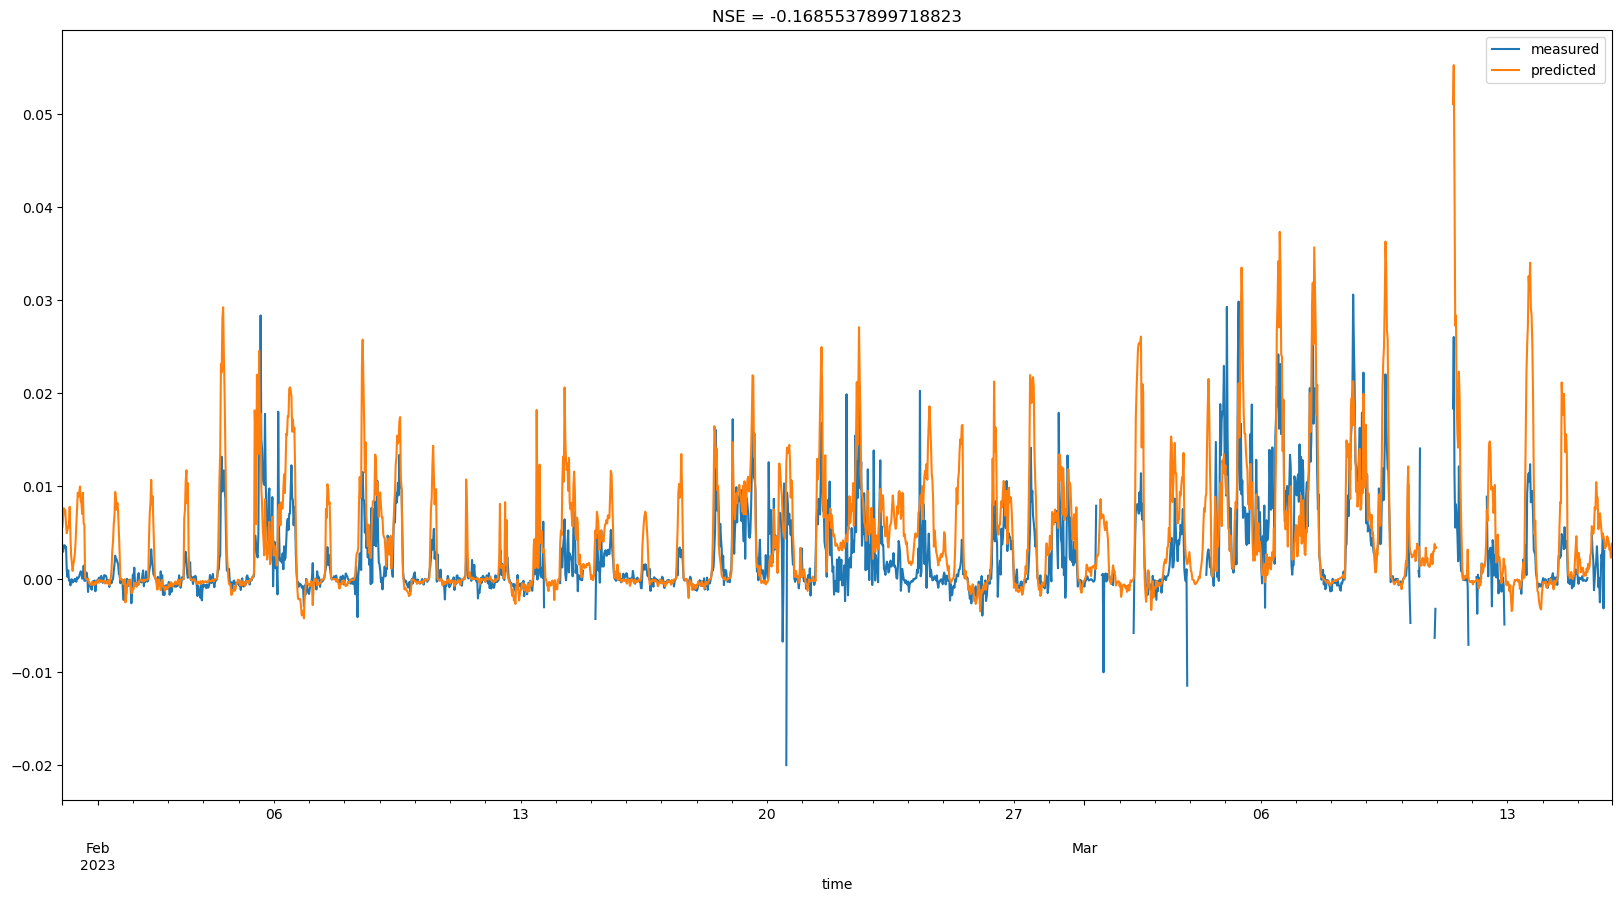

In [25]:
plt.figure(figsize=(20,10))
targets = tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20230131': '20230315']['value']
predictions = model_df[
    model_df.config == "MO Holtslag de Bruin Tsurf_c e_sat_alduchov 1e-05"
].set_index('time').loc['20230131': '20230315']['latent heat flux']

targets.plot(label='measured')
predictions.plot(label='predicted')
plt.legend()
plt.title(f"NSE = {nse(predictions, targets)}")

# Calculate measured daily cumulative sublimation (for plotting)

In [ ]:
tidy_df_daily = tidy_df_5Min[tidy_df_5Min.measurement == 'Cumulative sublimation measured'].set_index('time').groupby(
    [pd.Grouper(freq='1440Min'), 'tower', 'height', 'measurement', 'variable']
).max().reset_index()

# Calculate model cumulative sublimation

In [ ]:
model_df_cumsum = pd.DataFrame(model_df.sort_values("time").set_index(
    ["time", "config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"]
).groupby(["config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"])['latent heat flux'].cumsum()).reset_index()

model_df_cumsum_daily = pd.DataFrame(model_df_cumsum.set_index("time").groupby(
    [pd.Grouper(freq='1440Min'), 'config', "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"]
)['latent heat flux'].max()).reset_index()

model_df_cumsum_daily = model_df_cumsum_daily[
    model_df_cumsum_daily.time < '2023-05-10'
][
    model_df_cumsum_daily.time >= '2022-11-30'
]

from metpy.constants import density_water
seconds_per_30min = 60*30
model_df_cumsum_daily['latent heat flux (mm)'] = model_df_cumsum_daily['latent heat flux'].values * seconds_per_30min/density_water.magnitude

# Calculate my own Model cumulative sublimation

In [ ]:
modeled_lhflux_variables = tidy_df_30Min[tidy_df_30Min.variable.str.contains('w_h2o__3m_c predicted')].variable.unique()

In [ ]:
seconds_per_30min = 60*30 
for var in modeled_lhflux_variables:
    print(var)
    this_df = tidy_df_30Min[tidy_df_30Min.variable == var]
    cumulative_sublimation_values = np.nancumsum(this_df.value.values*seconds_per_30min)/metpy.constants.density_water.magnitude
    new_var_name = var + ' cumulative mm SWE'
    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min,
        cumulative_sublimation_values,
        new_var_name,
        "Cumulative sublimation predicted",  
        height,
        tower
    )

# Plot

In [ ]:
my_own_modeled_chart = alt.Chart(
    tidy_df_30Min[
        tidy_df_30Min.variable != 'w_h2o__3m_c predicted (0.005) cumulative mm SWE'
    ].query("measurement == 'Cumulative sublimation predicted'").query("height > 1")
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Cumulative sublimation (mm)"),
    color = 'variable:N',
    tooltip = 'variable'
).properties(width = 250, height = 250)
my_own_modeled_chart

In [ ]:
my_own_modeled_chart = alt.Chart(
    tidy_df_30Min[tidy_df_30Min.variable.isin([
        'w_h2o__3m_c predicted (1e-05) cumulative mm SWE',
        'w_h2o__3m_c predicted (5e-05) cumulative mm SWE',
        'w_h2o__3m_c predicted (0.0001) cumulative mm SWE',
    ])]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Cumulative sublimation (mm)"),
    color = 'variable:N'
).properties(width = 250, height = 250)
my_own_modeled_chart

In [ ]:
measurements_chart = alt.Chart(
    tidy_df_daily.query("measurement == 'Cumulative sublimation measured'").query("height > 1")
).mark_line(opacity=0.5, strokeWidth=1).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Cumulative sublimation (mm)").scale(domain=[-5, 150]),
    detail = 'variable:N',
    tooltip = 'variable'
).properties(width = 250, height = 250)

In [ ]:
models_chart = alt.Chart(
    model_df_cumsum_daily.query("z0 <= 1.e-03").dropna()
).mark_line(opacity = 0.5, color='grey', strokeWidth=0.2).encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm)").scale(domain=[-5, 150]),
    detail = 'config'
)

In [ ]:
snowpillow_chart = alt.Chart(
    tidy_df_30Min.query("variable == 'SWE_p2_c'").dropna()
).transform_window(
    frame = [-48, 48],
    rolling_median = 'median(value)'
).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("rolling_median:Q").title(["Snow water", "equivalent (mm)"])
).properties(width = 250, height = 83)

# snowpillow_and_precip_chart = snowpillow_chart +\
# alt.Chart(
#     precip_df
# ).mark_line(strokeDash=[2,4]).encode(
#     alt.X('date:T'),
#     alt.Y("acc_prec")
# )

In [ ]:
(
    snowpillow_chart &
    (measurements_chart)
)

In [ ]:
(
    snowpillow_chart &
    (measurements_chart + models_chart + my_own_modeled_chart)
)

In [ ]:
model_df_cumsum_daily.query("z0 <= 1.e-03").dropna().z0.unique()

In [ ]:



models_chart_by_z0 = alt.Chart(
    model_df_cumsum_daily.query("z0 <= 1.e-03").dropna()
).mark_line(opacity = 0.75, color='grey', strokeWidth=0.2).encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm)").scale(domain=[-5, 150]),
    alt.Color('z0:O').scale(
        domain = [1.e-03, 1.e-04,  1.e-05],
        range = ['#d62728', '#ff7f0e', '#bcbd22']
    ),
    detail = 'config'
)


(
    snowpillow_chart &
    (measurements_chart + models_chart_by_z0)
)

In [ ]:
models_chart_by_ts_meas = alt.Chart(
    model_df_cumsum_daily[model_df_cumsum_daily.config.isin([
    'MO Holtslag de Bruin Tsurf_rad_d e_sat_alduchov 1e-05',
    'MO Holtslag de Bruin Tsurf_d e_sat_alduchov 1e-05',
])]
).mark_line(opacity = 0.75, color='grey', strokeWidth=0.2).encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm)").scale(domain=[-5, 150]),
    alt.Color('z0:O').scale(
        domain = [1.e-03, 1.e-04,  1.e-05],
        range = ['#d62728', '#ff7f0e', '#bcbd22']
    ),
    detail = 'config'
)


(
    snowpillow_chart &
    (measurements_chart + models_chart_by_z0)
)

In [ ]:
start_date = "2023-03-01"
end_date = "2023-03-05"
meas_chart = alt.Chart(
    tidy_df_30Min.set_index('time').sort_index().loc[start_date:end_date].reset_index().query("variable == 'w_h2o__3m_c'")
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q")

)
model_chart = alt.Chart(
    model_df[model_df.config == 'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 1e-05'].set_index('time').sort_index().loc[start_date:end_date].reset_index()
).mark_line(color='red').encode(
    alt.X("time:T"),
    alt.Y("latent heat flux:Q")
)

(meas_chart + model_chart).properties(width = 600)

# Explore the data points we left out, based on the thresholds (for filtering data) that we determined earlier
# These are the datapoints we don't trust and are excluding - we should get an idea of what's happening during these limited times
* Measurements during times where SF_avg_XX_ue measurements are > 10^0, and have “good data” counts less than 0.9*6000 
* If too much data, only remove isolated incidents (I.e. less than 2 of those data points in a row)


In [ ]:
ec_lhflux_and_counts_variables

In [ ]:
bad_data = tidy_df_5Min[
    tidy_df_5Min.variable.isin(['SF_avg_2m_ue', 'SF_avg_1m_ue'])
].query("value > 1")

In [ ]:
bad_data = bad_data.sort_values('time')
bad_data['month'] = bad_data.time.dt.month

In [ ]:
alt.Chart(
    bad_data
).mark_tick().encode(
    alt.X("time:T").title(None),
    alt.Row("month:O").sort([12,1,2,3,4])
).resolve_scale(x='independent', y='shared').properties(width=400)

Select a few case studies based on the plot of bad data occurences above

In [ ]:
case_study_ls = [
    ("20221213", "20221215"),
    ("20221221", "20221223"),
    ("2023-01-10 12:00:00" , "2023-01-10 14:00:00"),
    ("20230205", "20230207"),
    ("20230308", "20230310"),
    ("20230330", "20230401"),
    ("20230403", "20230404"),
    

]

In [ ]:
src = tidy_df_5Min[
        tidy_df_5Min.variable.isin(list(sum(ec_lhflux_and_counts_variables, ())) + [
            'spd_3m_c', 'spd_5m_c', 'spd_10m_c', 'spd_15m_c', 'spd_20m_c',
            'spd_3m_d', 'spd_10m_d',
            'spd_3m_ue', 'spd_10m_ue',
            'spd_3m_uw', 'spd_10m_uw',
        ])
    ].set_index('time').sort_index()
src['tower and height'] = src.apply(lambda row : row['tower'] + ' ' + str(row['height']), axis=1)

In [ ]:
alt.Chart(
    src[
        case_study_ls[0][0]: case_study_ls[0][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[1][0]: case_study_ls[1][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[2][0]: case_study_ls[2][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[3][0]: case_study_ls[3][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[4][0]: case_study_ls[4][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[5][0]: case_study_ls[5][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[6][0]: case_study_ls[6][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)